In [32]:
#All needed packages

import numpy as np
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed
import os
import time
import matplotlib.pyplot as plt

In [33]:
#Parallel computing settings to use 16CPUs. Additonal setting is required while launching via terminal

Parallelism().set('tensor', nproc=16)
Parallelism().set(nproc=16)
Parallelism()

Number of processes for parallelization:
 - linbox computations: 16
 - tensor computations: 16

In [34]:
#Defining all the needed values

#Those will be explicidly computed
z = var('z')

x,y = var('x,y',domain='real')
mu = var('mu',domain='complex')

#Those will have an imput as a basis
avg_m = 1
delta_m = 0
z1 = 2/10

#Fixing compatibility issue between packages
T = QQ[i]

In [35]:
#Zetas

zeta = x + I*y
zeta_bar = x - I*y

#I here denotes a square root of -1, bar stands for conjugates

In [36]:
#Looking for the expression for the lens equation

z_bar(z) = zeta_bar - (avg_m + delta_m)/(z1 - z) - (avg_m - delta_m)/(-z1-z)
L(z) = zeta - z - (avg_m + delta_m)/(z1 - z_bar(z)) - (avg_m - delta_m)/(-z1 - z_bar(z))

#Expaning and keeping just the numerator of the expression
exp1(z) = L(z).numerator(normalize=true)

In [37]:
#Looking for the expression for the magnification

#derivative of z
derivative_z(z) = (delta_m + avg_m)/(z1 - z_bar(z))^2 + (avg_m - delta_m)/(z1+z_bar(z))^2

#and its conjugate
derivative_z_bar(z) = (delta_m + avg_m)/(z1 - z)^2 + (avg_m - delta_m)/(z1+z)^2

#magnification polynomial
magnification(z) = mu*(1-derivative_z(z)*derivative_z_bar(z))-1

In [38]:
#Expaning and keeping just the numerator of the expression
exp2(z) = magnification(z).numerator(normalize=true)

In [39]:
#Function which constructs a resultant for each x and y
def resultant(xs,ys):
    
    #Plugging in x and y
    temp1 = exp1.subs({x:xs,y:ys})
    temp2 = exp2.subs({x:xs,y:ys})
    
    #Rings in SageMath are needed for operations on polynomials.
    #They are responsible for errors.
    #T generates numbers complex numbers a+bI where a and b are rational
    #It drasticlly aids computations
    #Each ring is responsible for coefficients of a variable. R and S are subrings of QQI
    QQI.<I> = T
    R.<mu> = QQI[]
    S.<z> = R[]

    #Recreating polynomials on the said rings
    poly1 = temp1.polynomial(None,ring=S)
    poly2 = temp2.polynomial(None,ring=S)

    #Resultant is computed with Sylvester's method in SageMath
    poly3 = poly1.resultant(poly2)
    
    return poly3

In [40]:
def magn(xs,ys):
    
    #Looking for roots of resultant(mu) on complex numbers
    roots = resultant(xs,ys).roots(ring=CDF)
    
    #Applying total magnification definition
    mag = sum([abs(roots[k][0].n(50)) for k in range(len(roots))])
    
    #Returning log scale for better visability
    return log(mag)

In [41]:
#Code is working for any rational number
#However, creating a grid with 'simpler' fractions make it faster

x_list = []
for u in range(36):
    x_list.append(u/35)
    
for u in range(1,36):
    x_list.append(-u/35)
x_list.sort()
y_list = x_list

In [42]:
#List of fractions sorted
print(x_list)

[-1, -34/35, -33/35, -32/35, -31/35, -6/7, -29/35, -4/5, -27/35, -26/35, -5/7, -24/35, -23/35, -22/35, -3/5, -4/7, -19/35, -18/35, -17/35, -16/35, -3/7, -2/5, -13/35, -12/35, -11/35, -2/7, -9/35, -8/35, -1/5, -6/35, -1/7, -4/35, -3/35, -2/35, -1/35, 0, 1/35, 2/35, 3/35, 4/35, 1/7, 6/35, 1/5, 8/35, 9/35, 2/7, 11/35, 12/35, 13/35, 2/5, 3/7, 16/35, 17/35, 18/35, 19/35, 4/7, 3/5, 22/35, 23/35, 24/35, 5/7, 26/35, 27/35, 4/5, 29/35, 6/7, 31/35, 32/35, 33/35, 34/35, 1]


In [43]:
#An empty matrix for storing results
A = np.zeros([71,71])

In [44]:
#Parallel computing loop for the faster results

if __name__ == '__main__':
    pool_size = min(os.cpu_count(), len(x_list) * len(y_list))
    with ProcessPoolExecutor(max_workers=pool_size) as executor:
        # create mapping between the Future instance returned by submit and the original m, n indexes:
        futures = {executor.submit(magn, x_list[m], y_list[n]): (m, n) for m in range(len(x_list)) for n in range(len(y_list))}
        for future in as_completed(futures):
            m, n = futures[future] # original indexes
            result = future.result()
            A[m][n] = result #our matrix filled with vaulues

In [45]:
#We want to examine magnification for x = y
#Instead of recalculating, we can just pull A[i,i] entries

c_line = []
for k in range(71):
    c_line.append(A[k,k])

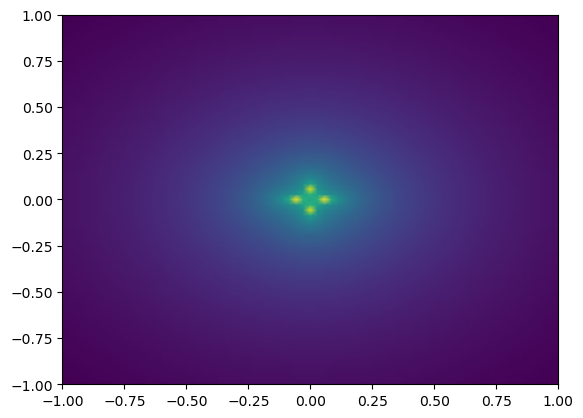

In [50]:
#Subplots are needed for shadow
fig,ax = plt.subplots(1,1)

#Mapping a matrix and applying shadow based on lowest and highest value
ax.pcolormesh(x_list, y_list, A, shading='gouraud', vmin=A.min(), vmax=A.max())

plt.savefig('2lens-z210.png')

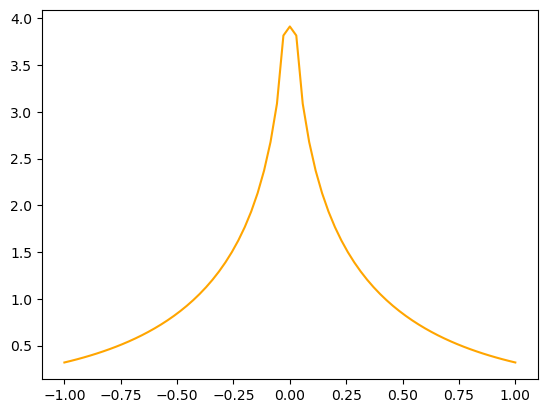

In [51]:
#Magnification line for pulled out entries. 'Sharp pikes' are where the function diverges.

plt.plot(x_list,c_line,color='orange')
plt.savefig("2lens-m210-mag.png")